In [1]:
import geopandas as gpd
import pandas as pd
import os

# Porject and Control polygons

In [2]:
path = "data/car/acre/"
folders = [name for name in os.listdir(path) if "SHAPE" in name]
df = gpd.GeoDataFrame()
for folder in folders:
    df_new = gpd.read_file(path + folder + "/AREA_IMOVEL/AREA_IMOVEL.shp")
    df = pd.concat([df, df_new])
# df = df.to_crs("EPSG:4326")

In [3]:
df.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
df.head()

,COD_IMOVEL,NUM_AREA,COD_ESTADO,NOM_MUNICI,NUM_MODULO,TIPO_IMOVE,SITUACAO,CONDICAO_I,geometry
0,AC-1200203-960F42AA267B42AA99796B9BA2014065,104.831639,AC,Cruzeiro do Sul,1.0483,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.44126 -7.79968, -72.41918 -7.795..."
1,AC-1200203-AD3A9DC93BEA4F9E9191410507E768F3,98.999439,AC,Cruzeiro do Sul,0.9900,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.43808 -7.81534, -72.43284 -7.814..."
2,AC-1200203-E3E678F3F10E4F43930A798A3CB21024,33.116394,AC,Cruzeiro do Sul,0.3312,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.39974 -7.75967, -72.39692 -7.759..."
3,AC-1200203-FDBE7665A84543D39A3A1426DFB99D93,93.019743,AC,Cruzeiro do Sul,0.9302,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.33497 -7.77499, -72.33939 -7.774..."
4,AC-1200203-ABA3D38DC7934EDB8FCF6B00C50FA0AB,2.960736,AC,Cruzeiro do Sul,0.0296,IRU,AT,Aguardando anÃ¡lise,"POLYGON ((-72.81086 -7.57448, -72.80826 -7.572..."


<Axes: >

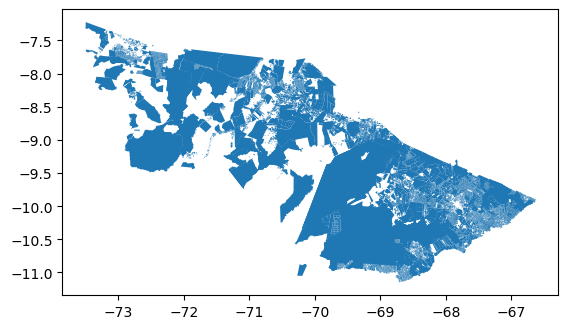

In [141]:
df.plot()

In [5]:
df.geometry.to_crs("EPSG:6933").area

0       1.047063e+06
1       9.888043e+05
2       3.307546e+05
3       8.853969e+05
4       2.958828e+04
            ...     
1389    5.211794e+05
1390    8.583391e+04
1391    6.614004e+05
1392    5.788279e+05
1393    5.594047e+05
Length: 41902, dtype: float64

In [6]:
import fiona

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
path_pa = "data/pa/ValparaisoProperty (Kml).kml"
pa = gpd.read_file(path_pa, driver='KML')
pa = pa.to_crs(df.crs)

<Axes: >

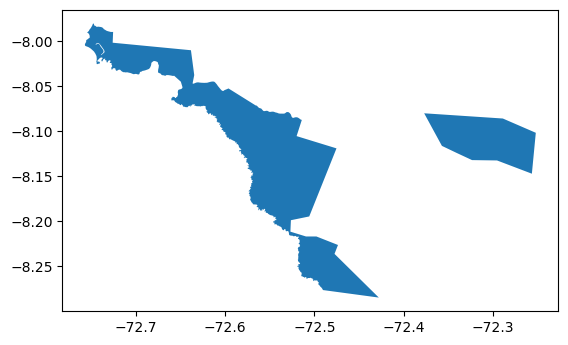

In [144]:
pa.plot()

In [7]:
pa.to_crs("EPSG:6933").area.sum()

289886589.1948548

# Biomass data

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window

In [149]:
year = 2021
# path_bio = "data/biomass/brasil_coverage_1985.tif"
path_bio = "data/biomass/" + f"mapbiomas-brazil-collection-70-acre-{year}.tif"
bio_data = rasterio.open(path_bio)
print(bio_data.bounds)
print(bio_data.shape)
print(df.geometry.total_bounds)

BoundingBox(left=-73.9919841647147, bottom=-11.145846887712963, right=-66.62355304672433, top=-7.110165473806013)
(1797, 3281)
[-73.51306721 -11.14745306 -66.62422657  -7.22364747]


In [150]:
lon_inc = abs(bio_data.bounds.left - bio_data.bounds.right) / bio_data.width
lat_inc = abs(bio_data.bounds.top - bio_data.bounds.bottom) / bio_data.height

bbox = df.geometry.total_bounds
lon_off_min = int((bbox[0] - bio_data.bounds.left) / lon_inc) 
lat_off_min = int((bio_data.bounds.top - bbox[3]) / lat_inc)  
lon_off_max = int((bbox[2] - bio_data.bounds.left) / lon_inc) 
lat_off_max = int((bio_data.bounds.top - bbox[1]) / lat_inc) 
lon_window = lon_off_max - lon_off_min
lat_window = lat_off_max - lat_off_min
bbox_window = Window(lon_off_min, lat_off_min, lon_window, lat_window)
# bio_acre = bio_data.read(1, window=bbox_window)

bio_acre = bio_data.read(1)

In [151]:
np.unique(bio_acre)

array([ 0,  3,  4, 11, 12, 15, 24, 33, 41], dtype=uint8)

In [152]:
class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
             10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
             14:2,15:2,18:2,19:2,39:2,20:2,40:2,61:2,41:2,36:2,46:2,47:2,48:2,9:2,21:2, # farming
             22:3,23:3,24:3,30:3,25:3, # urban
             26:4,33:4,31:4, # water
             27:5,0:5} # unobserved
for i in range(bio_acre.shape[0]):
    for j in range(bio_acre.shape[1]):
        bio_acre[i,j] = class_dict[bio_acre[i,j]]

In [153]:
np.unique(bio_acre)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

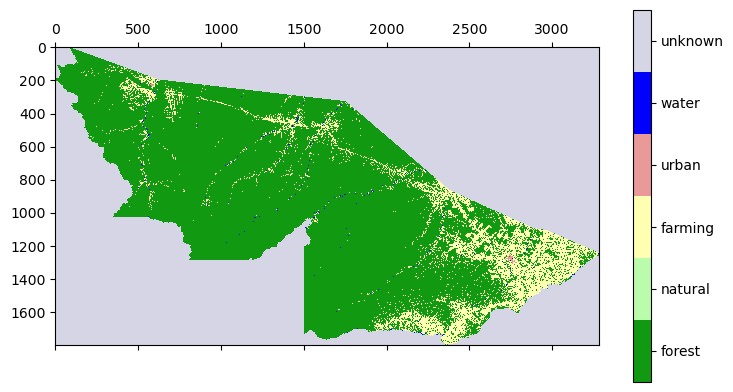

In [154]:
from matplotlib import colors
cmap = colors.ListedColormap(['#129912','#bbfcac','#ffffb2','#ea9999','#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_acre,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()